In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [ ]:
# Mount the Google Drive as folder directory for the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Projects/GSoC 2021'

/content/drive/MyDrive/Projects/GSoC 2021


In [ ]:
# Note: please change the current directory to the correct directory of the .py file if you want to run this code
from tf_keras_model import get_particle_net, get_particle_net_lite
from tf_keras_model_static import get_particle_net_static, get_particle_net_lite_static

# Task IV: Classical Graph Neural Network (GNN) Part

Problem statement: use ParticleNet’s data for Quark/Gluon jet classification[1], then **choose 2 Graph-based architectures of your choice to classify jets as being quarks (label = 1) or gluons (label = 0)**. **Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges**. **Discuss the resulting performance of the 2 chosen architectures**.

## The Approach Used to Tackle the Problem

### Dataset and Hardware Limitation
Since Google Colab offers a limited ammount of RAM, this project only used the first 9 files of data (without charm and bottom jets) from reference [1]. This is also need to be done considering limited ammount of time available for the training process. Each file has 100k jets, exactly 50k quark and 50k gluon jets, randomly sorted (label imbalance is not an issue). Every jet in the file contains $M$ x $F$ data where $M$ is the maximum number of multiplicity of the jets in the file and $F$ is the number of each particle's features (pt, rapidity, azimuthal angle, and pdgid/Particle Data Group ID). So, in total, 900k jets are used in this project.

### Point-cloud - to - Graph Projection and Choosing Graph-based Architectures

How to project the point-cloud dataset to graphs is strongly interdependent with the network architectures. This project will follow mainly the reference [2] but with some changes to explore things that is not yet explored in the paper.

ParticleNet, a state-of-the-art graph-based network architecture recently published, proposed to treat a jet as an unordered set of its constituent particles or "particle cloud"[2]. One main advantage of using this representation is that incorporating additional nonadditive information of the particles, like the pdgid, is straightforward. It is proven in reference [2] that including the pdgid data in the model's training improved the model's performance.

The paper utilized Dynamic Graph Convolutional Neural Network (DGCNN) with "EdgeConv" operation as its unique selling point[3]. This operation treats every particle in the particle cloud as a vertice in a graph with its k nearest neighboring particles as the edges, explicitly exploits the local spatial structure of particle clouds.

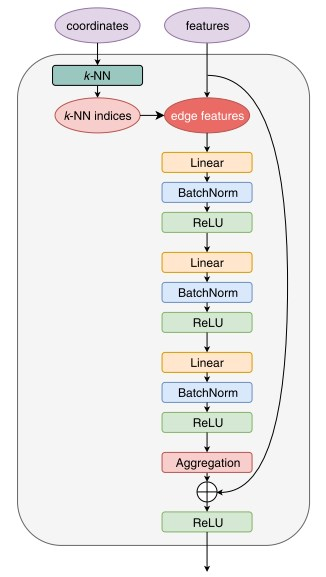

**Figure 1**: The inner structure of an EdgeConv block[2].

Equation below defines an EdgeConv operation on a point $x_{i}$ used in reference [2]
$$
\boldsymbol{x}_{i}^{\prime}=\frac{1}{k}\sum_{j=1}^{k} h_{\Theta}\left(\boldsymbol{x}_{i}, \boldsymbol{x}_{i_{j}}-\boldsymbol{x}_{i}\right)
$$
where $\boldsymbol{x}_{i}$ is the feature vector of the point $x_{i}$, $\boldsymbol{x}_{i_{j}}$ denoted the feature vector of the k nearest neighboring points of point $x_{i}$ with index $j$, and $h_{\Theta}$ is a multilayer perceptron whose parameters are shared between all edges. One time of this operation application is depicted as an "EdgeConv block" in the **Figure 2**.

Reference [2] also explain how they update the graph "dynamically" along the network. The set of k nearest neighboring particles for every particle is updated at the beginning of every EdgeConv block. The first block will use the rapidity and azimuthal angle to determine the distances, while the rest of the block will use the learned feature vectors from the previous block as coordinates.

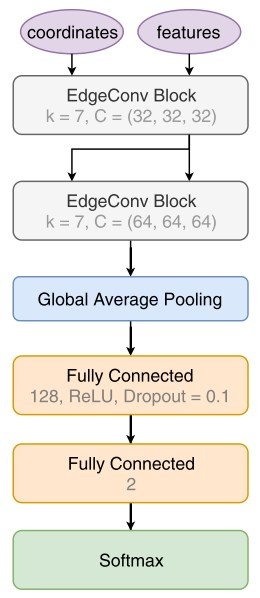

**Figure 2**: ParticleNet-Lite networks architecture[2]. $k$ is the number of nearest neighboring particles, and $C$ = ($C_{1}$, $C_{2}$, $C_{3}$) is the number of channels.

After reading reference [2] and its [code implementation](https://github.com/hqucms/ParticleNet), there are three important parts which in my opinion are keys in obtaining the state-of-the-art performance achieved by the paper:
1. The EdgeConv operation itself that exploits the local spatial structure of particle clouds.
2. The "dynamic" aspect of updating the graph by changing the set of k nearest neighboring particles for every particle along the network.
3. The particle cloud representation.

I think it is interesting to explore which of them gives more significant improvement to the performance since the original paper does not discuss about this. Therefore, this project will follow the ParticleNet architecture implemented in reference [2] (the "lite" version will be used to shorten the training time needed) and compare it with the modified version that doesn't dynamically update the graph. Every EdgeConv block in this modified version will use the same set of nearest neighboring particles as the first block, which is to use the rapidity and azimuthal angle data in the dataset.

By comparing the performance of these two architectures, we should be able to conclude the importance of the "dynamic" aspect in ParticleNet architecture, at least for the "lite" version.

## Code Implementation

In this project, all features in the dataset (pt, rapidity, azimuthal angle and pdgid) will be used as the particle's features. The rapidity and azimuthal angle will be used to calculate the distance for k-NN.

Since each file have different value of $M$, all jets in every file will be padded with zeros to have the same size of $M$. The particles will then be masked with a "mask" array that gives information whether the particle is a real particle from the dataset or just a padded "zero-particles".

### Load and Check the Dataset

The function below will do the $M$ padding between two dataset files.

In [ ]:
def dataset_padding(X_1, X_2, y_1, y_2):
    if X_1.shape[1] != X_2.shape[1]:
        if X_1.shape[1] > X_2.shape[1]:
            X_2 = np.concatenate((X_2,np.zeros((X_2.shape[0], X_1.shape[1]-X_2.shape[1], X_2.shape[2]))), axis=1)
        else:
            X_1 = np.concatenate((X_1,np.zeros((X_1.shape[0], X_2.shape[1]-X_1.shape[1], X_1.shape[2]))), axis=1)

        X_1 = np.concatenate((X_1,X_2), axis=0)
        y_1 = np.concatenate((y_1,y_2), axis=0)

    return X_1, y_1

Let's load the first 9 files of the dataset from reference [1]. Since there are two classes to be classified, quarks (label = 1) or gluons (label = 0), and a softmax activation function is used at the end of the ParticleNet-Lite networks, the labels need to be transformed to one-hot format.

In [ ]:
# Load the dataset
# Note: please change the directory to the correct directory of the dataset if you want to run this code
with np.load('./jet-data/QG_jets.npz') as data:
    X_train = data["X"]
    y_train = data["y"]
    print("Dataset QG_jets.npz has been loaded.")
    
for i in range(8):
    with np.load('./jet-data/QG_jets_' + str(i+1) + '.npz') as data:
        temp_X = data["X"]
        temp_y = data["y"]
        print("Dataset QG_jets_" + str(i+1) + ".npz has been loaded.")
        X_train, y_train = dataset_padding(X_train, temp_X, y_train, temp_y)

# Transform the labels to one-hot format
y_train = tf.keras.utils.to_categorical(y_train)

# Sanity check
print("Whole dataset shape:", X_train.shape, y_train.shape)

Dataset QG_jets.npz has been loaded.
Dataset QG_jets_1.npz has been loaded.
Dataset QG_jets_2.npz has been loaded.
Dataset QG_jets_3.npz has been loaded.
Dataset QG_jets_4.npz has been loaded.
Dataset QG_jets_5.npz has been loaded.
Dataset QG_jets_6.npz has been loaded.
Dataset QG_jets_7.npz has been loaded.
Dataset QG_jets_8.npz has been loaded.
Whole dataset shape: (900000, 142, 4) (900000, 2)


In [ ]:
num_samples = X_train.shape[0]
num_particles = X_train.shape[1]
num_features = X_train.shape[2]

print("Total number of samples:", num_samples)
print("Maximum number of particles in a jet:", num_particles)
print("Number of features:", num_features)

Total number of samples: 900000
Maximum number of particles in a jet: 142
Number of features: 4


### Preprocess the Dataset

Split 80% of the data for training set, 10% for validation set, and 10% for testing set as suggested in the reference [2].

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train, y_train, random_state=2021)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2021)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=2021)

# Sanity check
print("Train dataset shape:", X_train.shape, y_train.shape)
print("Val dataset shape:", X_val.shape, y_val.shape)
print("Test dataset shape:", X_test.shape, y_test.shape)

Train dataset shape: (720000, 142, 4) (720000, 2)
Val dataset shape: (90000, 142, 4) (90000, 2)
Test dataset shape: (90000, 142, 4) (90000, 2)


Create a dictionary that contains the "points", "features", and "mask" array for training set, validation set, and testing set.

- "points" contains only rapidity and azimuthal angle value, this will be used to calculate distance for k-NN.
- "features" contains all the features (pt, rapidity, azimuthal angle), this will be used as the particle's features for training.
- "mask" gives information whether the particle is a real particle from the dataset or just a padded "zero-particles" (taking value of zero for the padded positions).

In [ ]:
train_dict = {
    # the coordinates of the particles in the (eta, phi) space (shape=num_samples,num_particles,2)
    'points': X_train[:, :, 1:3],
    # the features of the particles (shape=num_samples,num_particles,num_features)
    'features': X_train,
    # a mask array, taking a value of 0 for padded positions (shape=num_samples,num_particles,1)
    'mask': np.sum(X_train, axis=2).reshape(len(X_train), num_particles, 1)
}

val_dict = {
    # the coordinates of the particles in the (eta, phi) space (shape=num_samples,num_particles,2)
    'points': X_val[:, :, 1:3],
    # the features of the particles (shape=num_samples,num_particles,num_features)
    'features': X_val,
    # a mask array, taking a value of 0 for padded positions (shape=num_samples,num_particles,1)
    'mask': np.sum(X_val, axis=2).reshape(len(X_val), num_particles, 1)
}

test_dict = {
    # the coordinates of the particles in the (eta, phi) space (shape=num_samples,num_particles,2)
    'points': X_test[:, :, 1:3],
    # the features of the particles (shape=num_samples,num_particles,num_features)
    'features': X_test,
    # a mask array, taking a value of 0 for padded positions (shape=num_samples,num_particles,1)
    'mask': np.sum(X_test, axis=2).reshape(len(X_test), num_particles, 1)
}

### Dynamic Graph CNN

Now let's start first with the "dynamic" version, the original architecture proposed in reference [2].

#### Initialize and Train the Model

Initialize the dynamic/original version of the ParticleNet-Lite model.

In [ ]:
model_type = 'particle_net_lite'
num_classes = 2
input_shapes = {k:train_dict[k].shape[1:] for k in train_dict}

if 'lite' in model_type:
    model_dynamic = get_particle_net_lite(num_classes, input_shapes)
else:
    model_dynamic = get_particle_net(num_classes, input_shapes)

print("Input shapes:", input_shapes)

Input shapes: {'points': (142, 2), 'features': (142, 4), 'mask': (142, 1)}


The hyperparameters ($k$, $C$, batch size, and learning rate) used in this project will be kept the same as the original paper so the comparison will be fair, both for the "dynamic" and "static" version.

The number of epochs is chosen as 20 based on trial and error. I found that the training and validation performance start to converge after about 15 epochs.

In [ ]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 20

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [ ]:
model_dynamic.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', tf.keras.metrics.AUC()])
model_dynamic.summary()

[2021-03-21 13:50:31,173] INFO: Learning rate: 0.001000


Model: "ParticleNet_Lite_Dynamic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 142, 1)]     0                                            
__________________________________________________________________________________________________
tf.math.not_equal_1 (TFOpLambda (None, 142, 1)       0           mask[0][0]                       
__________________________________________________________________________________________________
tf.cast_2 (TFOpLambda)          (None, 142, 1)       0           tf.math.not_equal_1[0][0]        
__________________________________________________________________________________________________
tf.math.equal_1 (TFOpLambda)    (None, 142, 1)       0           tf.cast_2[0][0]                  
___________________________________________________________________________

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [lr_scheduler, progress_bar]

Let's train the model.

In [ ]:
history_dgcnn = model_dynamic.fit(train_dict, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_dict, y_val),
          shuffle=True,
          callbacks=callbacks)

[2021-03-21 13:51:05,137] INFO: Learning rate: 0.001000


Epoch 1/20
704/704 [==============================] - 316s 449ms/sample - loss: 0.4792 - accuracy: 0.7773 - auc_1: 0.8512 - val_loss: 0.4369 - val_accuracy: 0.8062 - val_auc_1: 0.8795


[2021-03-21 13:56:21,263] INFO: Learning rate: 0.001000


Epoch 2/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4384 - accuracy: 0.8045 - auc_1: 0.8787 - val_loss: 0.4578 - val_accuracy: 0.7900 - val_auc_1: 0.8676


[2021-03-21 14:01:32,468] INFO: Learning rate: 0.001000


Epoch 3/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4286 - accuracy: 0.8098 - auc_1: 0.8846 - val_loss: 0.4352 - val_accuracy: 0.8074 - val_auc_1: 0.8833


[2021-03-21 14:06:43,541] INFO: Learning rate: 0.001000


Epoch 4/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4237 - accuracy: 0.8124 - auc_1: 0.8874 - val_loss: 0.4152 - val_accuracy: 0.8180 - val_auc_1: 0.8923


[2021-03-21 14:11:54,555] INFO: Learning rate: 0.001000


Epoch 5/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4192 - accuracy: 0.8150 - auc_1: 0.8900 - val_loss: 0.4231 - val_accuracy: 0.8163 - val_auc_1: 0.8914


[2021-03-21 14:17:05,453] INFO: Learning rate: 0.001000


Epoch 6/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4179 - accuracy: 0.8158 - auc_1: 0.8907 - val_loss: 0.4101 - val_accuracy: 0.8215 - val_auc_1: 0.8962


[2021-03-21 14:22:16,460] INFO: Learning rate: 0.001000


Epoch 7/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4146 - accuracy: 0.8173 - auc_1: 0.8925 - val_loss: 0.4169 - val_accuracy: 0.8157 - val_auc_1: 0.8916


[2021-03-21 14:27:27,432] INFO: Learning rate: 0.001000


Epoch 8/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4145 - accuracy: 0.8175 - auc_1: 0.8926 - val_loss: 0.4096 - val_accuracy: 0.8194 - val_auc_1: 0.8953


[2021-03-21 14:32:38,470] INFO: Learning rate: 0.001000


Epoch 9/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4117 - accuracy: 0.8187 - auc_1: 0.8942 - val_loss: 0.4068 - val_accuracy: 0.8227 - val_auc_1: 0.8971


[2021-03-21 14:37:49,609] INFO: Learning rate: 0.001000


Epoch 10/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4112 - accuracy: 0.8191 - auc_1: 0.8944 - val_loss: 0.4071 - val_accuracy: 0.8233 - val_auc_1: 0.8964


[2021-03-21 14:43:00,825] INFO: Learning rate: 0.001000


Epoch 11/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4101 - accuracy: 0.8194 - auc_1: 0.8950 - val_loss: 0.4156 - val_accuracy: 0.8159 - val_auc_1: 0.8921


[2021-03-21 14:48:11,837] INFO: Learning rate: 0.000100


Epoch 12/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4052 - accuracy: 0.8222 - auc_1: 0.8976 - val_loss: 0.4011 - val_accuracy: 0.8246 - val_auc_1: 0.8998


[2021-03-21 14:53:23,080] INFO: Learning rate: 0.000100


Epoch 13/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4046 - accuracy: 0.8228 - auc_1: 0.8980 - val_loss: 0.4002 - val_accuracy: 0.8257 - val_auc_1: 0.9004


[2021-03-21 14:58:34,360] INFO: Learning rate: 0.000100


Epoch 14/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4041 - accuracy: 0.8231 - auc_1: 0.8982 - val_loss: 0.3990 - val_accuracy: 0.8265 - val_auc_1: 0.9010


[2021-03-21 15:03:45,529] INFO: Learning rate: 0.000100


Epoch 15/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4038 - accuracy: 0.8229 - auc_1: 0.8984 - val_loss: 0.4008 - val_accuracy: 0.8249 - val_auc_1: 0.9000


[2021-03-21 15:08:56,784] INFO: Learning rate: 0.000100


Epoch 16/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4043 - accuracy: 0.8230 - auc_1: 0.8981 - val_loss: 0.3987 - val_accuracy: 0.8264 - val_auc_1: 0.9010


[2021-03-21 15:14:07,933] INFO: Learning rate: 0.000100


Epoch 17/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4034 - accuracy: 0.8232 - auc_1: 0.8986 - val_loss: 0.3987 - val_accuracy: 0.8262 - val_auc_1: 0.9012


[2021-03-21 15:19:19,088] INFO: Learning rate: 0.000100


Epoch 18/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4038 - accuracy: 0.8228 - auc_1: 0.8984 - val_loss: 0.3984 - val_accuracy: 0.8265 - val_auc_1: 0.9012


[2021-03-21 15:24:30,250] INFO: Learning rate: 0.000100


Epoch 19/20
704/704 [==============================] - 311s 442ms/sample - loss: 0.4030 - accuracy: 0.8237 - auc_1: 0.8988 - val_loss: 0.3982 - val_accuracy: 0.8267 - val_auc_1: 0.9014


[2021-03-21 15:29:41,304] INFO: Learning rate: 0.000100


Epoch 20/20
704/704 [==============================] - 311s 441ms/sample - loss: 0.4034 - accuracy: 0.8234 - auc_1: 0.8986 - val_loss: 0.3983 - val_accuracy: 0.8266 - val_auc_1: 0.9012


One important thing to be noticed here, as we will compare it later, is the time needed to train the model for 1 epoch, which is 311s/epoch.

In [ ]:
# save the training history as csv file
import csv

w = csv.writer(open("./train_history_dgcnn.csv", "w"))
for key, val in history_dgcnn.history.items():
    w.writerow([key, val])

In [ ]:
# save the last model
model_dynamic.save("./model_save/model_dynamic")

INFO:tensorflow:Assets written to: ./model_save/model_dynamic/assets


[2021-03-21 15:39:11,821] INFO: Assets written to: ./model_save/model_dynamic/assets


#### Plot the Training History

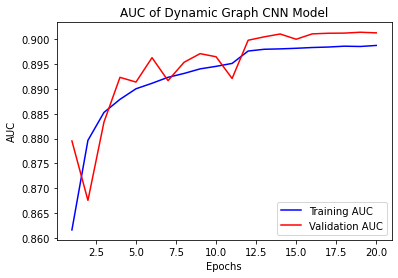

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['auc_1'], color='blue', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['val_auc_1'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of Dynamic Graph CNN Model")
plt.legend()
plt.show()

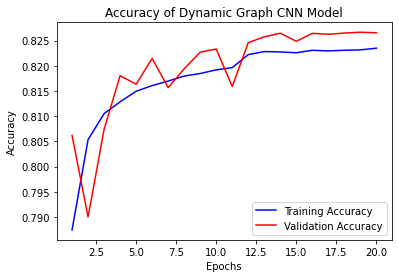

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Dynamic Graph CNN Model")
plt.legend()
plt.show()

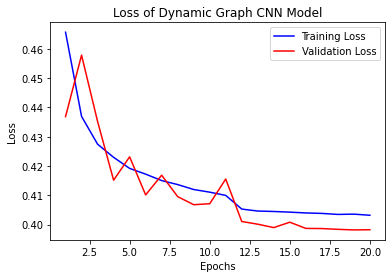

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['loss'], color='blue', label='Training Loss')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Dynamic Graph CNN Model")
plt.legend()
plt.show()

From the plots, it can be seen that the model converged before 20 epochs. The accuracy and AUC obtained are comparable to the values reported in reference [2], considering this project only used less than half of the available dataset (900k out of 2000k in total). A more in-depth discussion will be given later after the training of the "static" version of the model is done.

### Static Graph CNN

For this static version, we will train the modified version of ParticleNet-Lite that does not update the graph along the EdgeConv operation.

#### Initialize and Train the Model

Initialize the static/modified version of the ParticleNet-Lite model.

In [ ]:
model_type = 'particle_net_lite_static'
num_classes = 2
input_shapes = {k:train_dict[k].shape[1:] for k in train_dict}

if 'lite' in model_type:
    model_static = get_particle_net_lite_static(num_classes, input_shapes)
else:
    model_static = get_particle_net_static(num_classes, input_shapes)

print("Input shapes:", input_shapes)

Input shapes: {'points': (142, 2), 'features': (142, 4), 'mask': (142, 1)}


The exact same hyperparameters as the dynamic version will be used to ensure fairness.

In [ ]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 20

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [ ]:
model_static.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', tf.keras.metrics.AUC()])
model_static.summary()

[2021-03-21 12:18:06,362] INFO: Learning rate: 0.001000


Model: "ParticleNet_Lite_Static"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 142, 1)]     0                                            
__________________________________________________________________________________________________
tf.math.not_equal (TFOpLambda)  (None, 142, 1)       0           mask[0][0]                       
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 142, 1)       0           tf.math.not_equal[0][0]          
__________________________________________________________________________________________________
tf.math.equal (TFOpLambda)      (None, 142, 1)       0           tf.cast[0][0]                    
____________________________________________________________________________

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [lr_scheduler, progress_bar]

Let's train the model.

In [ ]:
history_sgcnn = model_static.fit(train_dict, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_dict, y_val),
          shuffle=True,
          callbacks=callbacks)

[2021-03-21 12:18:30,277] INFO: Learning rate: 0.001000


Epoch 1/20
704/704 [==============================] - 246s 349ms/sample - loss: 0.4681 - accuracy: 0.7867 - auc: 0.8595 - val_loss: 0.4412 - val_accuracy: 0.8037 - val_auc: 0.8778


[2021-03-21 12:22:35,878] INFO: Learning rate: 0.001000


Epoch 2/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4306 - accuracy: 0.8093 - auc: 0.8834 - val_loss: 0.4394 - val_accuracy: 0.8044 - val_auc: 0.8796


[2021-03-21 12:26:07,350] INFO: Learning rate: 0.001000


Epoch 3/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4234 - accuracy: 0.8124 - auc: 0.8876 - val_loss: 0.4166 - val_accuracy: 0.8173 - val_auc: 0.8916


[2021-03-21 12:29:38,794] INFO: Learning rate: 0.001000


Epoch 4/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4185 - accuracy: 0.8153 - auc: 0.8904 - val_loss: 0.4133 - val_accuracy: 0.8190 - val_auc: 0.8932


[2021-03-21 12:33:10,159] INFO: Learning rate: 0.001000


Epoch 5/20
704/704 [==============================] - 212s 301ms/sample - loss: 0.4168 - accuracy: 0.8162 - auc: 0.8913 - val_loss: 0.4247 - val_accuracy: 0.8105 - val_auc: 0.8870


[2021-03-21 12:36:41,807] INFO: Learning rate: 0.001000


Epoch 6/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4140 - accuracy: 0.8174 - auc: 0.8929 - val_loss: 0.4074 - val_accuracy: 0.8227 - val_auc: 0.8964


[2021-03-21 12:40:12,771] INFO: Learning rate: 0.001000


Epoch 7/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4126 - accuracy: 0.8185 - auc: 0.8936 - val_loss: 0.4703 - val_accuracy: 0.7800 - val_auc: 0.8615


[2021-03-21 12:43:43,750] INFO: Learning rate: 0.001000


Epoch 8/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4113 - accuracy: 0.8193 - auc: 0.8943 - val_loss: 0.4089 - val_accuracy: 0.8209 - val_auc: 0.8960


[2021-03-21 12:47:14,653] INFO: Learning rate: 0.001000


Epoch 9/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4105 - accuracy: 0.8197 - auc: 0.8947 - val_loss: 0.4277 - val_accuracy: 0.8100 - val_auc: 0.8853


[2021-03-21 12:50:45,544] INFO: Learning rate: 0.001000


Epoch 10/20
704/704 [==============================] - 211s 299ms/sample - loss: 0.4094 - accuracy: 0.8203 - auc: 0.8954 - val_loss: 0.4284 - val_accuracy: 0.8108 - val_auc: 0.8870


[2021-03-21 12:54:16,353] INFO: Learning rate: 0.001000


Epoch 11/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4078 - accuracy: 0.8213 - auc: 0.8962 - val_loss: 0.4121 - val_accuracy: 0.8202 - val_auc: 0.8941


[2021-03-21 12:57:47,333] INFO: Learning rate: 0.000100


Epoch 12/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4030 - accuracy: 0.8230 - auc: 0.8987 - val_loss: 0.3966 - val_accuracy: 0.8288 - val_auc: 0.9021


[2021-03-21 13:01:18,341] INFO: Learning rate: 0.000100


Epoch 13/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4033 - accuracy: 0.8232 - auc: 0.8986 - val_loss: 0.3969 - val_accuracy: 0.8281 - val_auc: 0.9019


[2021-03-21 13:04:49,385] INFO: Learning rate: 0.000100


Epoch 14/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4024 - accuracy: 0.8237 - auc: 0.8991 - val_loss: 0.3958 - val_accuracy: 0.8289 - val_auc: 0.9024


[2021-03-21 13:08:20,350] INFO: Learning rate: 0.000100


Epoch 15/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4015 - accuracy: 0.8237 - auc: 0.8996 - val_loss: 0.3965 - val_accuracy: 0.8291 - val_auc: 0.9022


[2021-03-21 13:11:51,505] INFO: Learning rate: 0.000100


Epoch 16/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4018 - accuracy: 0.8239 - auc: 0.8994 - val_loss: 0.3957 - val_accuracy: 0.8287 - val_auc: 0.9025


[2021-03-21 13:15:22,778] INFO: Learning rate: 0.000100


Epoch 17/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4021 - accuracy: 0.8242 - auc: 0.8992 - val_loss: 0.3956 - val_accuracy: 0.8287 - val_auc: 0.9026


[2021-03-21 13:18:53,765] INFO: Learning rate: 0.000100


Epoch 18/20
704/704 [==============================] - 211s 300ms/sample - loss: 0.4011 - accuracy: 0.8248 - auc: 0.8998 - val_loss: 0.3953 - val_accuracy: 0.8295 - val_auc: 0.9027


[2021-03-21 13:22:24,749] INFO: Learning rate: 0.000100


Epoch 19/20
704/704 [==============================] - 211s 299ms/sample - loss: 0.4015 - accuracy: 0.8247 - auc: 0.8996 - val_loss: 0.3950 - val_accuracy: 0.8294 - val_auc: 0.9030


[2021-03-21 13:25:55,560] INFO: Learning rate: 0.000100


Epoch 20/20
704/704 [==============================] - 211s 299ms/sample - loss: 0.4011 - accuracy: 0.8244 - auc: 0.8998 - val_loss: 0.3965 - val_accuracy: 0.8284 - val_auc: 0.9020


Same as before, notice that the time needed to train the static model is 211s/epoch. This will be compared later.

In [ ]:
# save the training history as csv file
import csv

w = csv.writer(open("./train_history_sgcnn.csv", "w"))
for key, val in history_sgcnn.history.items():
    w.writerow([key, val])

In [ ]:
# save the last model
model_static.save("./model_save/model_static")

INFO:tensorflow:Assets written to: ./model_save/model_static/assets


[2021-03-21 13:45:56,428] INFO: Assets written to: ./model_save/model_static/assets


#### Plot the Training History

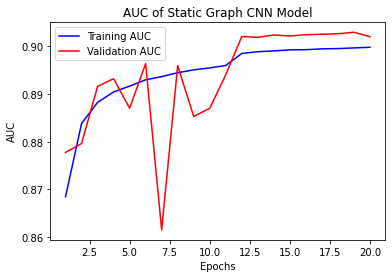

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['auc'], color='blue', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['val_auc'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of Static Graph CNN Model")
plt.legend()
plt.show()

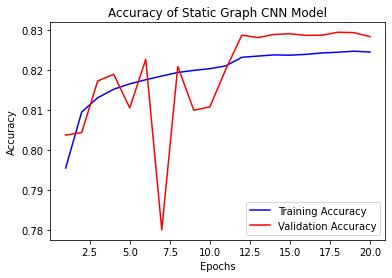

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Static Graph CNN Model")
plt.legend()
plt.show()

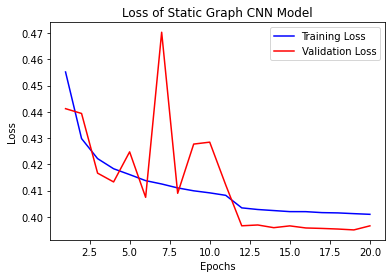

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['loss'], color='blue', label='Training Loss')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Static Graph CNN Model")
plt.legend()
plt.show()

One thing that really stood out from these plots is the instability of the training process. A more in-depth discussion will be given in the next section.

### Comparing the Model

Let's put the results from both models side by side for easier comparison.

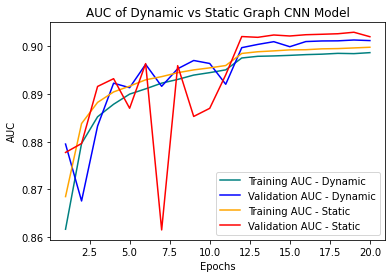

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['auc_1'], color='teal', label='Training AUC - Dynamic')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['val_auc_1'], color='blue', label='Validation AUC - Dynamic')

plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['auc'], color='orange', label='Training AUC - Static')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['val_auc'], color='red', label='Validation AUC - Static')

plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of Dynamic vs Static Graph CNN Model")
plt.legend()
plt.show()

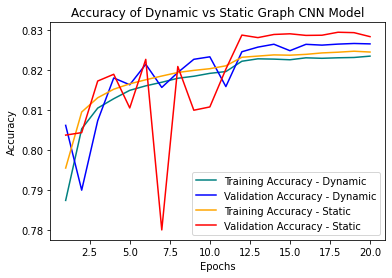

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['accuracy'], color='teal', label='Training Accuracy - Dynamic')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['val_accuracy'], color='blue', label='Validation Accuracy - Dynamic')

plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['accuracy'], color='orange', label='Training Accuracy - Static')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['val_accuracy'], color='red', label='Validation Accuracy - Static')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Dynamic vs Static Graph CNN Model")
plt.legend()
plt.show()

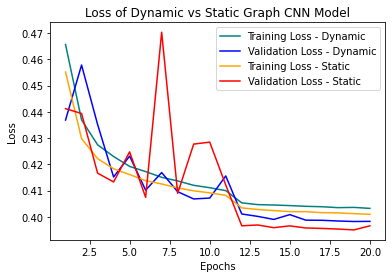

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['loss'], color='teal', label='Training Loss - Dynamic')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dgcnn.history['val_loss'], color='blue', label='Validation Loss - Dynamic')

plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['loss'], color='orange', label='Training Loss - Static')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_sgcnn.history['val_loss'], color='red', label='Validation Loss - Static')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Dynamic vs Static Graph CNN Model")
plt.legend()
plt.show()

From the plots, we can saw a general, consistent trend between the two models:

1. The static version is more unstable compared to the dynamic model. There are more (and deeper) local minima seems to exist in the loss landscape of the static version, shown by the more "jumpy" validation curve. This shows that dynamically updating the graph helps to stabilize the optimization process.

2. But interestingly, the static version final performance, when the models reached convergence, is consistently a little bit better than the dynamic one for both training and validation metric (lower loss, higher accuracy and AUC).

3. The training time for the static version (211s/epoch) is lowered than the dynamic version (311s/epoch). This is to be expected since the static version does not need to recalculate the nearest neighboring particles for every EdgeConv block in the network. The difference in time may differs from one hardware to another, but since the difference is quite significant, it is to be expected that the training time for the static model will still be significantly faster than the dynamic model.

From this results, one question arises, does the "dynamic" aspect of the ParticleNet is important in improving the model's performance? Considering it takes a more significant ammount of training time (and computational power) without a clear improvement in the performance, it is probably wise to reconsider the "static" option.

The ones that are significantly improving the performance compared to other approaches are probably the EdgeConv operation itself (without updating the graph dynamically) and the particle cloud representation.

Let's evaluate both models on testing set.

In [ ]:
# test dataset evaluation for DGCNN

loss, acc, auc = model_dynamic.evaluate(test_dict, y_test)
print("Evaluation Metric of Dynamic Graph CNN Model on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)

2813/2813 [==============================] - 41s 14ms/step - loss: 0.4032 - accuracy: 0.8240 - auc_1: 0.8987
Evaluation Metric of Dynamic Graph CNN Model on Test Dataset
Loss: 0.4032370150089264
Accuracy: 0.8239666819572449
AUC: 0.8986521363258362


In [ ]:
# test dataset evaluation for SGCNN

loss, acc, auc = model_static.evaluate(test_dict, y_test)
print("Evaluation Metric of Static Graph CNN Model on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)

2813/2813 [==============================] - 29s 10ms/step - loss: 0.4019 - accuracy: 0.8243 - auc: 0.8994
Evaluation Metric of Static Graph CNN Model on Test Dataset
Loss: 0.40190747380256653
Accuracy: 0.8243444561958313
AUC: 0.899357259273529


The table below summarizes all the best results obtained from both models in this project (when convergence is reach) and the original paper's results (reference [2]). Note that the model used in the original paper (ParticleNet-Lite w/ PID) is the same as the dynamic model used in this project, the difference is in the total number of dataset used.

In [2]:
import pandas as pd

summary = {'Accuracy': [0.825, 0.823, 0.829, 0.827, 0.824, 0.824, 0.835],
           'AUC': [0.8998, 0.8987, 0.9030, 0.9014, 0.8994, 0.8987, 0.9079]}
row_label = [
             'Train (Static)', 'Train (Dynamic)',
             'Validation (Static)', 'Validation (Dynamic)',
             'Test (Static)', 'Test (Dynamic)',
             'Reported in the Paper[2]'
             ]

pd.DataFrame(data=summary, index=row_label)

,Accuracy,AUC
Train (Static),0.825,0.8998
Train (Dynamic),0.823,0.8987
Validation (Static),0.829,0.9030
Validation (Dynamic),0.827,0.9014
Test (Static),0.824,0.8994
Test (Dynamic),0.824,0.8987
Reported in the Paper[2],0.835,0.9079


With the test set results now included, it is clear that the dynamic model does not offer a clear improvement in performance, both accuracy and AUC. The numerical results obtained here may include some uncertainty and this experiment needs to be carried out several times in the future to calculate the mean and the standard deviation. But at least this results show a clear indication that even without dynamically updating the graph between EdgeConv, the model still performed as well.

It is also interesting to note that the total samples used in the dataset mattered in the model's performance. The original paper used 2000k dataset, more than twice the dataset used in this project, and the performance of the original paper's model is indeed better (to be expected as more data usually means better model).

## Conclusion

In this project, two models based on reference [2] are trained to do quark-gluon tagging, using a much lower number of training samples. The first model is the dynamic model, the same model as the ParticleNet-Lite w/ PID from reference [2]. The second model is the static model, a similar architecture as the ParticleNet-Lite w/ PID but without dynamically updating the graph through the networks.

From the numerical results, we may conclude that the "dynamic" aspect of the first model does not show any clear improvement in the model's performance, at least for the lite version of ParticleNet. Considering that the first model significantly needs more training time, it is recommended to reconsider the second model (Static Graph CNN) as it is able to give a similar performance with lower training time (and computational power).

## References

[1] [P. Komiske, E. Metodiev, and J. Thaler, “Pythia8 Quark and Gluon Jets for Energy Flow,” May 2019.](https://zenodo.org/record/3164691#.Xk1VwS2B1QI) <br>
[2] [H. Qu and L. Gouskos, “Jet tagging via particle clouds,” Phys. Rev. D, vol. 101, no. 5, p. 056019, Mar. 2020.](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.101.056019) <br>
[3] [Y. Wang, Y. Sun, Z. Liu, S. E. Sarma, M. M. Bronstein, and J. M. Solomon, “Dynamic Graph CNN for Learning on Point Clouds,” ACM Trans. Graph., vol. 38, no. 5, p. Article 146, 2019.](https://dl.acm.org/doi/10.1145/3326362)